In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Cell 1: Import necessary libraries and mount Google Drive (if using Colab)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path to your mounted drive containing "healthy" and "patient" folders
data_dir = '/content/drive/MyDrive/dataset2'

# Define a directory to save the preprocessed images in Colab's file system
preprocessed_images_dir = '/content/preprocessed_images'
os.makedirs(preprocessed_images_dir, exist_ok=True)

# Create an ImageDataGenerator for data preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 256,  # Scale pixel values to be in the range [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate and save batches of preprocessed images
batch_size = 32
target_size = (256, 256)  # Resize images to 256x256 pixels

generator = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',  # Use 'categorical' for multi-class classification
    save_to_dir=preprocessed_images_dir,  # Specify the directory to save the preprocessed images
    save_prefix='preprocessed_',  # Prefix for saved image filenames
    save_format='jpeg'  # Format for saved images
)

# Generate and save the preprocessed images
for _ in range(len(generator)):
    next(generator)

# Define paths to your image folders
healthy_dir = '/content/drive/MyDrive/dataset2/healthy'
patient_dir = '/content/drive/MyDrive/dataset2/patient'


Found 594 images belonging to 2 classes.


In [1]:
# Cell 1: Import necessary libraries and mount Google Drive (if using Colab)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define paths to your image folders
healthy_dir = 'D:/vs mini/dataset2/reduced_healthy'
patient_dir = 'D:/vs mini/dataset2/reduced_patient'


In [3]:
# Cell 2: Initialize lists to store features and labels
all_features = []
labels = []

# Load pre-trained models
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define a function to extract features using a given model and preprocess input
def extract_features(model, preprocess_input, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()  # Flatten the features

# Load, preprocess, and extract features from healthy images
for filename in os.listdir(healthy_dir):
    img_path = os.path.join(healthy_dir, filename)
    resnet_features = extract_features(resnet_model, resnet_preprocess_input, img_path)
    vgg_features = extract_features(vgg_model, vgg_preprocess_input, img_path)
    inception_features = extract_features(inception_model, inception_preprocess_input, img_path)
    combined_features = np.concatenate((resnet_features, vgg_features, inception_features))
    all_features.append(combined_features)
    labels.append(0)  # Label 0 for healthy

# Load, preprocess, and extract features from patient images
for filename in os.listdir(patient_dir):
    img_path = os.path.join(patient_dir, filename)
    resnet_features = extract_features(resnet_model, resnet_preprocess_input, img_path)
    vgg_features = extract_features(vgg_model, vgg_preprocess_input, img_path)
    inception_features = extract_features(inception_model, inception_preprocess_input, img_path)
    combined_features = np.concatenate((resnet_features, vgg_features, inception_features))
    all_features.append(combined_features)
    labels.append(1)  # Label 1 for patient

# Convert lists to numpy arrays
X = np.array(all_features)
y = np.array(labels)


1/1 [==============================] - 0s 62ms/step


In [ ]:
# Cell 3: Define GA parameters
population_sizes = list(range(10, 51, 5))  # Vary population size from 10 to 50 with an increment of 5
total_iterations = 200
crossover_rate = 0.7
mutation_rate = 0.3
selection_candidates = 20
random_seed = 13

# Set random seed for reproducibility
np.random.seed(random_seed)

# Initialize lists to record peak accuracies for each population size
peak_accuracies = []

# Iterate through different population sizes
for population_size in population_sizes:
    # Reinitialize the population with binary vectors
    initial_population = np.random.randint(2, size=(population_size, X.shape[1]))
    best_accuracy = 0.0

    # Main GA loop
    for iteration in range(total_iterations):
        fitness_scores = []

        # Calculate fitness for each candidate in the population
        for candidate in initial_population:
            fitness = calculate_fitness(candidate)
            fitness_scores.append(fitness)

        # Select the top candidates with the best accuracies
        selected_indices = np.argsort(fitness_scores)[-selection_candidates:]
        selected_population = initial_population[selected_indices]

        # Perform crossover to create new candidates
        crossover_population = []
        for i in range(population_size // 2):
            parent1 = selected_population[np.random.randint(selection_candidates)]
            parent2 = selected_population[np.random.randint(selection_candidates)]
            crossover_point = np.random.randint(0, len(parent1))
            offspring1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            offspring2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            crossover_population.append(offspring1)
            crossover_population.append(offspring2)

        # Perform mutation
        for i in range(population_size):
            for j in range(len(crossover_population[i])):
                if np.random.rand() < mutation_rate:
                    crossover_population[i][j] = 1 - crossover_population[i][j]  # Flip the bit

        # Update the population for the next iteration
        initial_population = np.array(crossover_population)

        # Calculate the fitness of the best candidate
        best_fitness = max(fitness_scores)

        # Check if the current iteration achieved a new peak accuracy
        if best_fitness > best_accuracy:
            best_accuracy = best_fitness

    # Record the peak accuracy for this population size
    peak_accuracies.append(best_accuracy)

# Find the population size with the highest peak accuracy
best_population_size = population_sizes[np.argmax(peak_accuracies)]

# Freeze the algorithm at the best population size for future analyses
final_population_size = best_population_size

print(f"The best population size is {best_population_size}, and the peak accuracy is {max(peak_accuracies)*100:.2f}%")
print(f"The algorithm is frozen at population size {final_population_size} for future analyses.")


In [4]:
import numpy as np
loaded_best_feature_vector = np.load('D:/modelgraph/best_feature_vector.npy')

In [10]:
# Load the x and y feature vector
loaded_x = np.load('D:/modelgraph/X.npy')
loaded_y = np.load('D:/modelgraph/y.npy')
print("x and y vector loaded")

x and y vector loaded


In [12]:
from sklearn.model_selection import train_test_split
random_seed=80
X_train, X_test, y_train, y_test = train_test_split(loaded_x, loaded_y, test_size=0.3, random_state=random_seed)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
accuracy = knn.score(X_test, y_test)
accuracy

0.8994413407821229

Accuracy using the optimized feature set: 91.62%


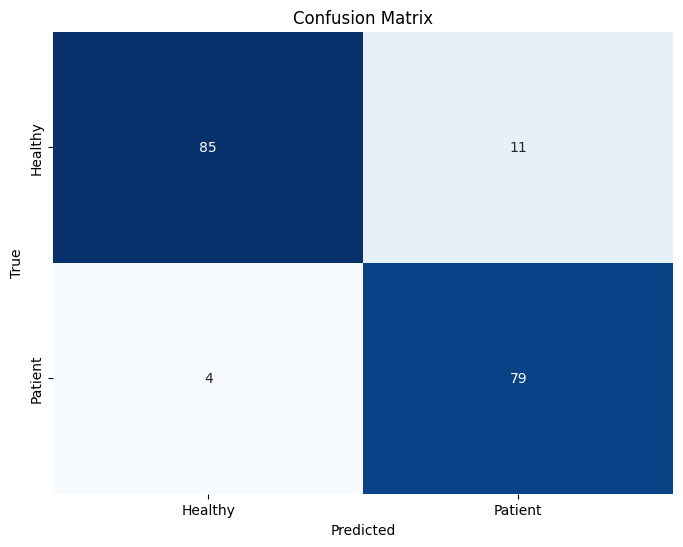

Total values successfully predicted: 164 (164)
Incorrect predictions: 15 (15)
Precision: 0.8777777777777778
Recall: 0.9518072289156626
F1-Score: 0.9132947976878613


In [13]:
# Cell 4: Assuming you have the best binary vector as 'best_vector' from the GA

# Select relevant features based on the best binary vector
selected_train_features = X_train[:, loaded_best_feature_vector == 1]
selected_test_features = X_test[:, loaded_best_feature_vector == 1]

# Train a KNN classifier on the selected training features
knn = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors
knn.fit(selected_train_features, y_train)

# Evaluate the KNN classifier on the selected testing features
accuracy = knn.score(selected_test_features, y_test)

print(f"Accuracy using the optimized feature set: {accuracy*100:.2f}%")

# Calculate the confusion matrix
y_pred = knn.predict(selected_test_features)
confusion = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Healthy", "Patient"], yticklabels=["Healthy", "Patient"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Calculate the number of correct and incorrect predictions
correct_predictions = np.diag(confusion).sum()
incorrect_predictions = confusion.sum() - correct_predictions

# Print the results
print(f"Total values successfully predicted: {correct_predictions} ({confusion[0, 0] + confusion[1, 1]})")
print(f"Incorrect predictions: {incorrect_predictions} ({confusion[0, 1] + confusion[1, 0]})")

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
